# 单层注意力分析

绘制两张图：
1. **2D 热力图**: Query Frame × Key Frame，3×4 网格显示 12 个 head
2. **Per-Head Grid**: 最后一个 block 对各帧的注意力柱状图

In [1]:
import math
import os

import papermill as pm
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams.update({
        "svg.fonttype": "none",
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,  
})

## 配置

In [2]:
# ============================================================
# 配置
# ============================================================

DATA_PATH = "../cache/layer29.pt"
SAVE_DIR = "attention_analysis/layer29"
SAVE_SVG = True

In [3]:
# Parameters
DATA_PATH = "../cache/lake_mist/layer16.pt"
SAVE_DIR = "attention_analysis/lake_mist/layer16"
SAVE_SVG = True


## 加载数据

In [4]:
data = torch.load(DATA_PATH, map_location="cpu", weights_only=False)

print("=" * 60)
print(f"Layer: {data['layer_index']}")
print(f"Prompt: {data.get('prompt', 'N/A')}")
print(f"Num frames: {data.get('num_frames', 'N/A')}")
print(f"Num heads: {data.get('num_heads', 'N/A')}")
print(f"Block sizes: {data.get('block_sizes', 'N/A')}")
print(f"Last block Q frames: {data.get('last_block_query_frames', 'N/A')}")

# 加载数据
layer_idx = data['layer_index']
num_frames = data['num_frames']
num_heads = data['num_heads']

# 完整的 frame×frame 注意力矩阵
full_frame_attn = data['full_frame_attention'].float().numpy()  # [num_heads, Q, K]
print(f"\nFull attention shape: {full_frame_attn.shape}")
print(f"Range: [{full_frame_attn.min():.4f}, {full_frame_attn.max():.4f}]")

# 最后一个 block 的帧注意力（用于柱状图）
last_block_attn = data['last_block_frame_attention'].float().numpy()  # [num_heads, K]
last_block_q_frames = data.get('last_block_query_frames', [18, 19, 20])
print(f"\nLast block attention shape: {last_block_attn.shape}")

Layer: 16
Prompt: A peaceful lake at dawn, soft morning mist, serene atmosphere
Num frames: 21
Num heads: 12
Block sizes: [3, 3, 3, 3, 3, 3, 3]
Last block Q frames: [18, 19, 20]

Full attention shape: (12, 21, 21)
Range: [-6.8164, 8.5469]

Last block attention shape: (12, 21)


## 图1: 2D 热力图 (Query Frame × Key Frame)

/tmp/ipykernel_127805/3468331261.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.98])


Saved: attention_analysis/lake_mist/layer16/layer16_2d_heatmap_all_heads.svg


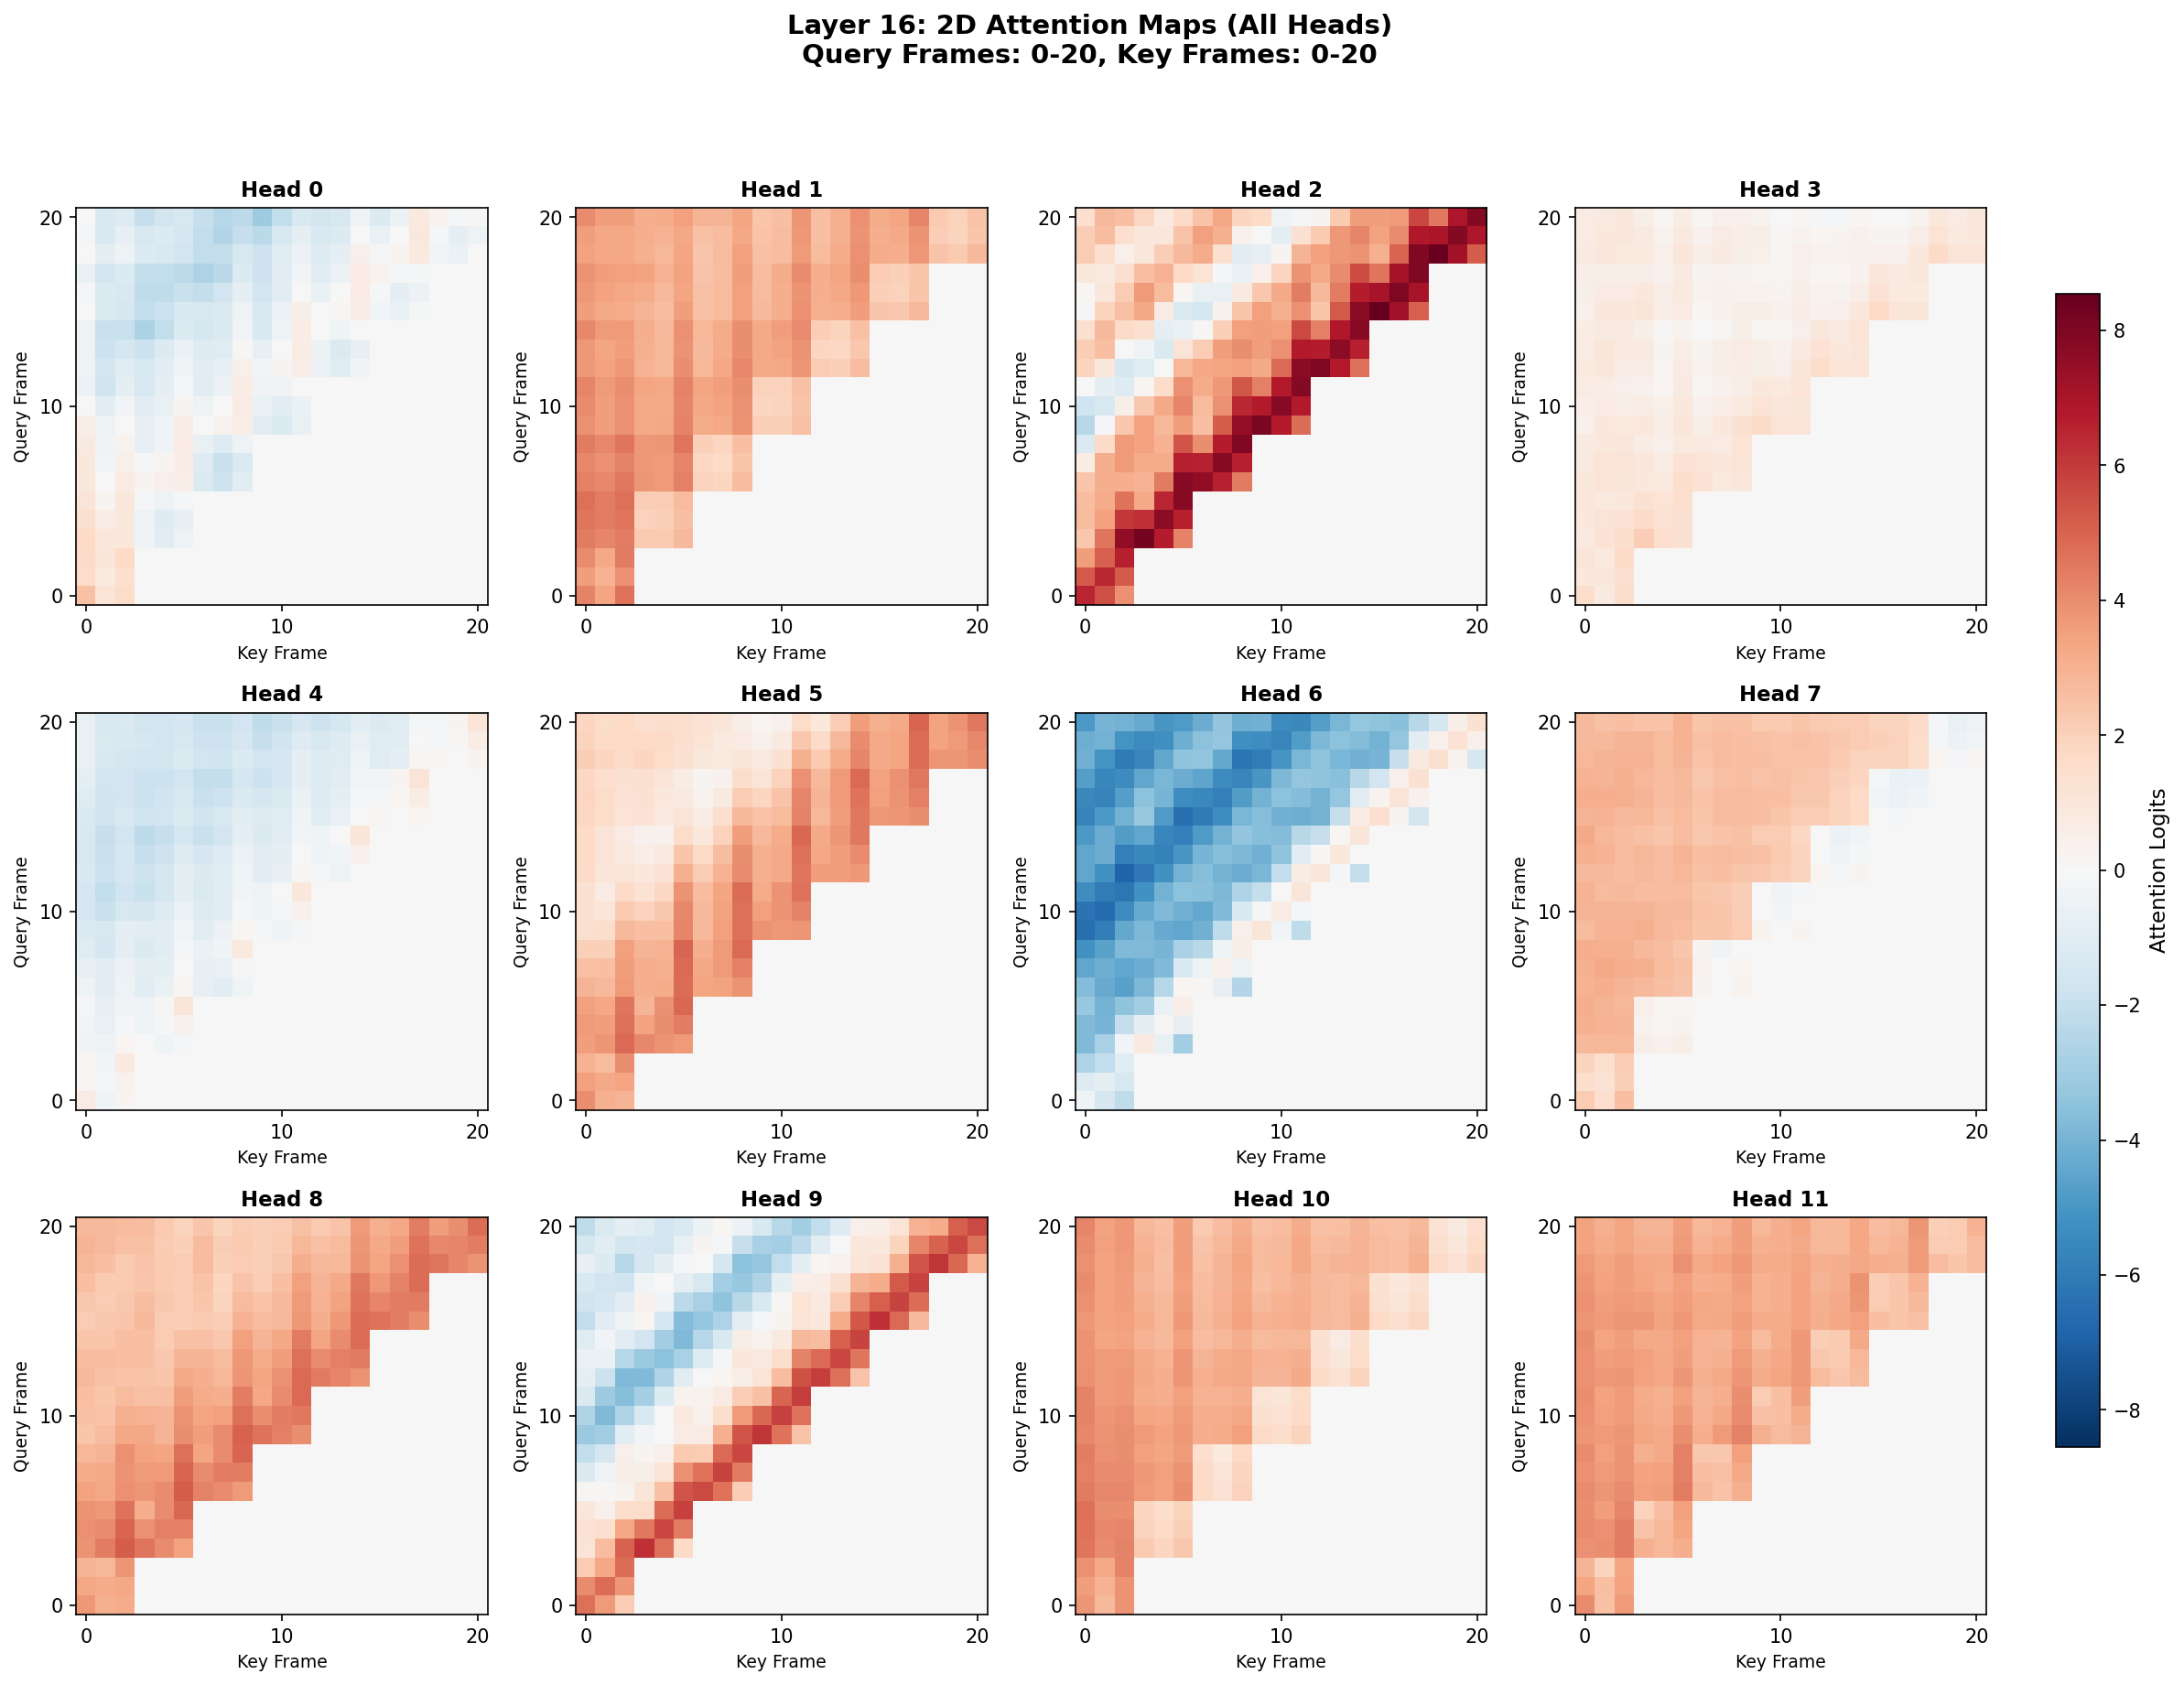

In [5]:
# ============================================================
# 图1: 2D 热力图 - 每个 head 一张小图
# X-axis: Key Frame Index (0-20)
# Y-axis: Query Frame Index (0-20)
# Layout: 3×4 grid for 12 heads
# ============================================================

ncols = 4
nrows = math.ceil(num_heads / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))
axes = axes.flatten()

# 全局 colorbar 范围（对称，便于 RdBu_r 显示）
vmax = max(abs(full_frame_attn.min()), abs(full_frame_attn.max()))
vmin = -vmax

for h in range(num_heads):
    ax = axes[h]
    attn_map = full_frame_attn[h]  # [Q, K]
    
    im = ax.imshow(
        attn_map,
        cmap="RdBu_r",
        aspect="auto",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest"
    )
    
    ax.set_title(f"Head {h}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Key Frame", fontsize=9)
    ax.set_ylabel("Query Frame", fontsize=9)
    
    # 设置刻度
    tick_pos = [0, num_frames // 2, num_frames - 1]
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_pos)
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_pos)

# 隐藏多余的子图
for k in range(num_heads, len(axes)):
    axes[k].axis("off")

# 添加 colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Attention Logits", fontsize=11)

fig.suptitle(
    f"Layer {layer_idx}: 2D Attention Maps (All Heads)\n"
    f"Query Frames: 0-{num_frames-1}, Key Frames: 0-{num_frames-1}",
    fontsize=14,
    fontweight="bold",
    y=1.02
)

plt.tight_layout(rect=[0, 0, 0.92, 0.98])

if SAVE_SVG:
    os.makedirs(SAVE_DIR, exist_ok=True)
    save_path = os.path.join(SAVE_DIR, f"layer{layer_idx}_2d_heatmap_all_heads.svg")
    plt.savefig(save_path, format="svg", bbox_inches="tight")
    print(f"Saved: {save_path}")

plt.show()

## 图2: Per-Head Grid (最后一个 block 对各帧的注意力)

Saved: attention_analysis/lake_mist/layer16/layer16_perhead_grid.svg


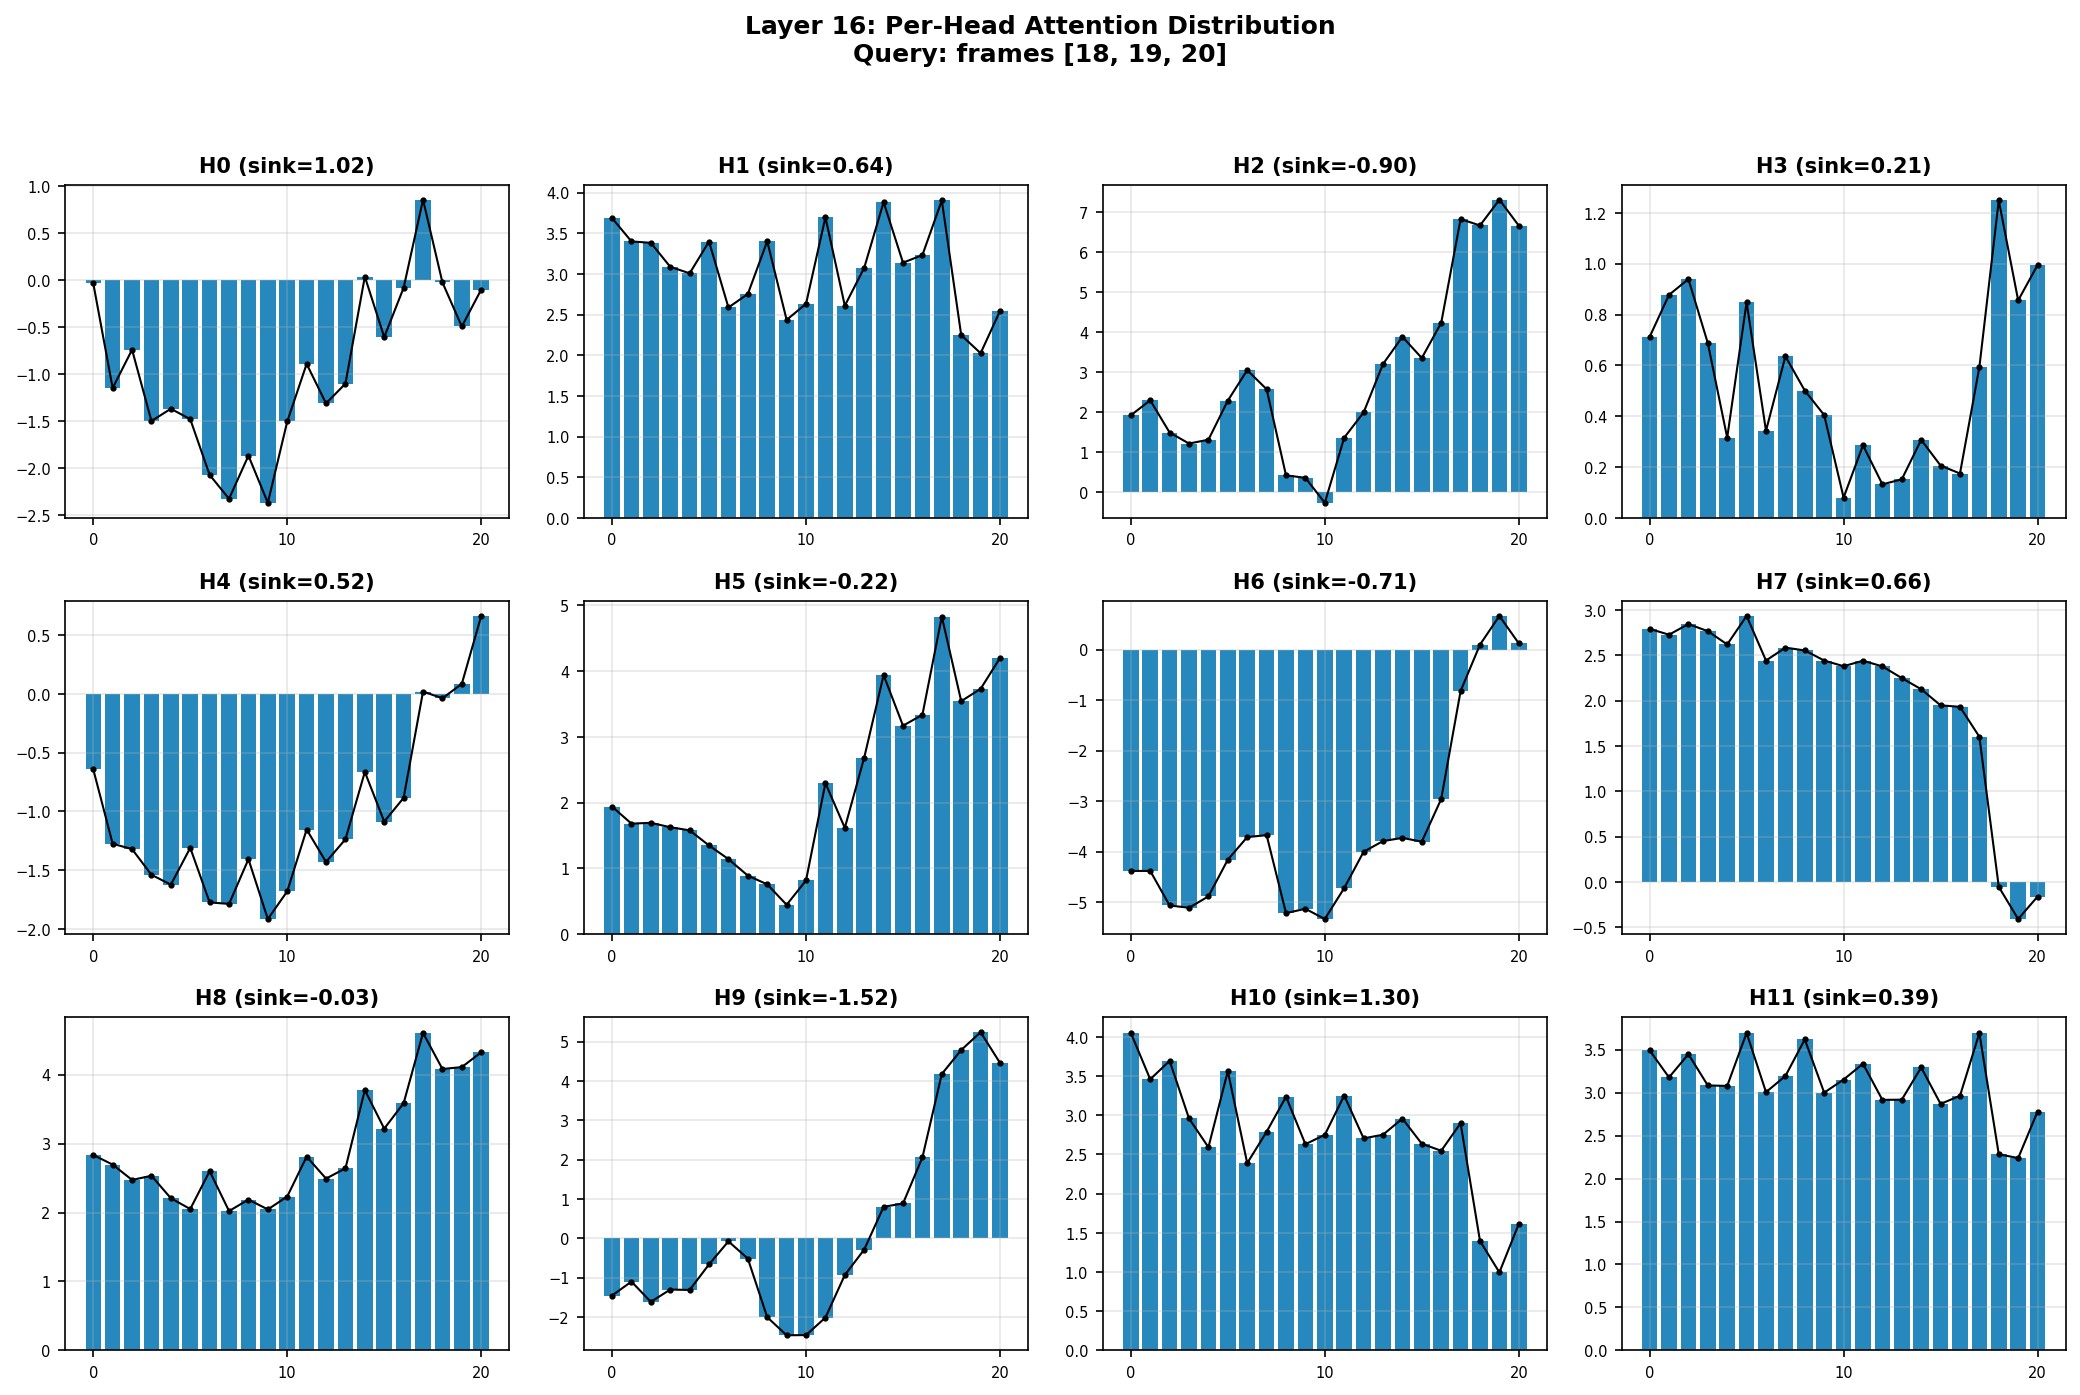

In [6]:
# ============================================================
# 图2: Per-Head Grid 柱状图
# 显示最后一个 block (frames 18-20) 对各 key frame 的注意力
# ============================================================

key_indices = np.arange(num_frames)

ncols = 4
nrows = math.ceil(num_heads / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows))
axes = axes.flatten()

BAR_COLOR = sns.color_palette("colorblind")[0]

for h in range(num_heads):
    ax = axes[h]
    head = last_block_attn[h]  # [K]
    
    # 计算 sink score (首帧 - 中间帧均值)
    first = head[0]
    middle = head[1:-1].mean() if len(head) > 2 else head.mean()
    sink_score = first - middle
    
    ax.bar(key_indices, head, alpha=0.85, width=0.8, color=BAR_COLOR)
    ax.plot(key_indices, head, "o-", color="black", linewidth=1, markersize=2)
    ax.set_title(f"H{h} (sink={sink_score:.2f})", fontsize=10, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.grid(True, alpha=0.3)
    
    if len(key_indices) > 10:
        ax.set_xticks([0, len(key_indices) // 2, len(key_indices) - 1])

for k in range(num_heads, len(axes)):
    axes[k].axis("off")

fig.suptitle(
    f"Layer {layer_idx}: Per-Head Attention Distribution\n"
    f"Query: frames {last_block_q_frames}",
    fontsize=12,
    fontweight="bold",
    y=1.00 + (0.01 * nrows),
)

plt.tight_layout()

if SAVE_SVG:
    os.makedirs(SAVE_DIR, exist_ok=True)
    save_path = os.path.join(SAVE_DIR, f"layer{layer_idx}_perhead_grid.svg")
    plt.savefig(save_path, format="svg", bbox_inches="tight")
    print(f"Saved: {save_path}")

plt.show()

## 统计

In [7]:
print("=" * 60)
print(f"Layer {layer_idx} Statistics")
print("=" * 60)

# 全局统计
diag = np.array([full_frame_attn[h, i, i] for h in range(num_heads) for i in range(num_frames)])
diag_mean = diag.mean()
first_col = full_frame_attn[:, :, 0]
first_col_mean = first_col[first_col != 0].mean() if (first_col != 0).any() else 0

print(f"Diagonal mean (self-attention): {diag_mean:.4f}")
print(f"First frame mean (sink): {first_col_mean:.4f}")

print("\nPer-Head Statistics (last block):")
for h in range(num_heads):
    head = last_block_attn[h]
    first = head[0]
    middle = head[1:-1].mean() if len(head) > 2 else head.mean()
    last = head[-1]
    sink = first - middle
    
    print(f"  H{h:2d}: first={first:7.3f}, mid={middle:7.3f}, last={last:7.3f}, sink={sink:+7.3f}")

Layer 16 Statistics
Diagonal mean (self-attention): 2.5948
First frame mean (sink): 1.4553

Per-Head Statistics (last block):
  H 0: first= -0.033, mid= -1.052, last= -0.100, sink= +1.019
  H 1: first=  3.688, mid=  3.048, last=  2.545, sink= +0.640
  H 2: first=  1.917, mid=  2.814, last=  6.656, sink= -0.897
  H 3: first=  0.712, mid=  0.505, last=  0.995, sink= +0.207
  H 4: first= -0.642, mid= -1.159, last=  0.666, sink= +0.518
  H 5: first=  1.940, mid=  2.165, last=  4.199, sink= -0.224
  H 6: first= -4.383, mid= -3.671, last=  0.126, sink= -0.712
  H 7: first=  2.791, mid=  2.131, last= -0.163, sink= +0.660
  H 8: first=  2.834, mid=  2.861, last=  4.324, sink= -0.027
  H 9: first= -1.453, mid=  0.064, last=  4.457, sink= -1.517
  H10: first=  4.051, mid=  2.747, last=  1.613, sink= +1.303
  H11: first=  3.492, mid=  3.103, last=  2.779, sink= +0.389
